# Intro:

In this exercise, I built and trained a neural network to classify images of clothing, like sneakers and shirts.  This guide uses tf.keras, a high-level API to build and train models in TensorFlow.

In [131]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [5]:
#Install and Import Dependencies
import tensorflow as tf
#import tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#Helper libraries
import math 
import numpy as np
import matplotlib.pyplot as plt

import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [16]:
#The model is trained using train_dataset
#The model is tested against test_dataset

dataset, metadata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'], dataset['test']


In [13]:
#Since the class names are not included with the dataset
#We will store them in class_names

class_names = ['T-shirts/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [15]:
#Explore the data
#Format the dataset before training the model
#Recall 60,000 images in the training set and 10,000 images in the testing set

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of training examples: {}'.format(num_train_examples))
print('Number of testing examples: {}'.format(num_test_examples))



Number of training examples: 60000
Number of testing examples: 10000


### Preprocess the data:
Note, the value of each pixel in the image is an integer in the range [0, 255].  For the model to work properly, these values need to be normalized to the range [0,1].  So here we create a normalization function, and then apply it to each image in the test and train dataset.


In [17]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images/= 255 # divides a variable by the value of the right operand and assigns the result to the variable.
    return images, labels

    #The map function applies the normalize function to each element in the train and test dataset
    train_dataset = train_dataset.map(normalize)
    test_dataset = test_datset.map(normalize)
    
    #Caching will keep them in memory, making training faster
    train_dataset = train_dataset.cache()
    test_dataset = test_dataset.cache()
    

### Plotting the images

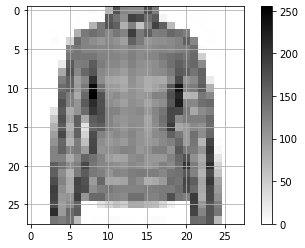

In [19]:
#Plot a single image and remove the color by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))
    
#Plot the image
plt.figure()
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(True)
plt.show()


Below is displayed the first 25 images from the training set and displays the class name below each image.  
We will verify that the data is in the correct format and they wer are ready to build and train the network.

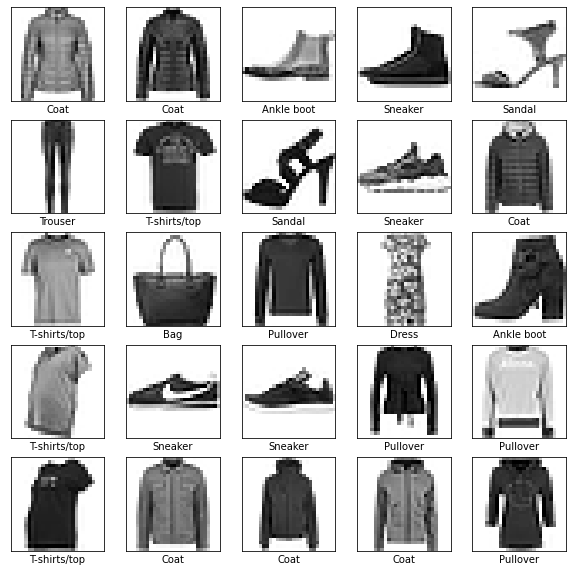

In [20]:
plt.figure(figsize = (10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap = plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1 
plt.show()

### Build the Model:
Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers
The basic building block of a neural network is the layer.  A layer extracts a representation from the data fed into it.  Hopefully a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of the deep learning consists of chaining together simple layers.  Most layers like, tf.keras.layers.Dense, have internal parameters which are adjusted ('learned') during training.


In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', activation = tf.nn.relu,
                            input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

### The Network Layers above:

#### Convolutions:
    tf.keras.layers.Conv2D and MaxPooling2D - The network starts with two pairs of Conv/MaxPool.  
    The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). 
    After that, the 32 outputs are reduced in size using a MaxPool2D (2,2) with a stride of 2.  
    The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reducted in size by a MaxPooling2D layer.  So far in the course, we have described what a Convolution does, but we haven't yet coverred how you chain multiples of these together.  
    
#### Outputs:
    tf.keras.layers.Dense - A 128 neuron, followed by 10-node softmax layer.  Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range [0,1], representing the probability that the image belongs to that class (class_names).  The sum of all 10 nodes values is 1.
    
 #### Note:
     Using softmax activation and SparseCategoricalCrossentropy() has issues and which are patched by the tf.keras model.  A safer approach, in general, is to use a linear output(no activation function) with SparseCategoricalCrossentropy(from_logits=True).


### Compile the Model:
    LOSS FUNCTION - An algorithm for measuring how far the model's ouputs are from the desired output.  The goal of training is measures loss.
    tf.keras.losses.SparseCategoricalCrossentropy()
    
    OPTIMIZER - An algorithm for adjusting the inner parameters of the model in order to minize loss.
    
    METRICS - Used to monitor the training and testing steps.  The following examples uses ["accuracy"], the fraction of the images that are correctly classified.

In [25]:
model.compile(optimizer = 'adam', 
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

### Train the Model:
####    First, we define the iteration behavoir for the train dataset:
        1. Repeat forever by specifying dataset.repeat() (The epochs parameters described below limits how long we perform training.).
        2. The dataset.shuffle(60000) randomizes the orders so our model cannot learn anything from the order of the examples.
        3. And dataset.batch(32) tell model.fit to use batches 32 images and labels when updating the model variables.
    
####    Training is performed by calling the model.fit method:
        1. Feed the training data to the model using train_dataset.
        2. The model learns to associate images and labels.
        3. The epochs=5 parameter limits training 5 full iterations of the training dataset, so as total of 5*60000 = 300000 examples.
    
    

In [26]:
#Training the model

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)



In [31]:
model.fit(train_dataset, epochs = 5, steps_per_epoch = math.ceil(num_train_examples/BATCH_SIZE))




Epoch 1/5
1875/1875 [==============================] - 65s 33ms/step - loss: 0.5918 - accuracy: 0.8535
Epoch 2/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2855 - accuracy: 0.8939
Epoch 3/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2461 - accuracy: 0.9091
Epoch 4/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2200 - accuracy: 0.9197
Epoch 5/5
1875/1875 [==============================] - 63s 34ms/step - loss: 0.1977 - accuracy: 0.9266


### Training Results (1st Attempt)
The trained model displays the loss and accuracy meters above.  This model reaches an average accuracy of .90056 (90%) on the training data.

### Evaluate Accuracy
Compare how the model perfroms on the test dataset.  Use all examples we have in the test dataset to set assess accuracy.


In [32]:
# Evaluate
test_loss, test_accuracy = model.evaluate(test_dataset, steps = math.ceil(num_test_examples / BATCH_SIZE))
print("Accuracy on test dataset:", test_accuracy)


313/313 [==============================] - 4s 11ms/step - loss: 0.3052 - accuracy: 0.9024
Accuracy on test dataset: 0.902400016784668


### Testing Results (1st Attempt)
The testing accuracy on the test dataset is slightly better than the average accuracy of the training dataset.  This is not the result that we should expect to see, since this is the first time our model has see the 10,000 images.  Our expected performace should have gone down.  



In [33]:
# Make Predictions and Explore:
#Use the model we train to make predictions about some images.
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)



In [34]:
predictions.shape

(32, 10)

The model has predicted the probability of each label for each image in the testing set.  
Now we will take a look at the first prediction:
predictions[0]

In [36]:
predictions[0]

array([4.6855284e-04, 5.8154948e-10, 8.4278211e-02, 1.0934346e-05,
       4.8620069e-01, 4.8522918e-11, 4.2903909e-01, 4.0369459e-09,
       2.5252580e-06, 2.8052624e-10], dtype=float32)

We see a prediction of an array of 10 numbers.  These describe the confidence of the model that the image corresponds to each of the 10 different articles of clothing.  It also expresses which label has the highest confidence value.  

In [44]:
b = np.argmax(predictions[0])
print("Highest Confidence value: {}".format(b))
print("Class Name: {}".format(class_names[b]))

Highest Confidence value: 4
Class Name: Coat


The numpy argmax showns that the label with the highest confidence value is 4 and class names is Coat.  Therefore our model is most confident that this image is a Coat or class_names[4]. 

In [45]:
#Now we need to check the label:
test_labels[0]

4

### Graphing the full set of 10 class predictions:

In [100]:
def plot_image(i, predictions_array, true_label, images):
    predictions_array, true_label, img = predictions_array[i], true_label[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap = plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]),
                                        color = color)
    
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks()
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color = '#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[predicted_label].set_color('blue')
    
    

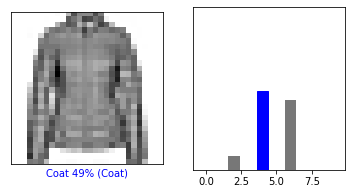

In [101]:
#We are going to look at the 0th image, prediction, and prediction array

i = 0
plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2,2)
plot_value_array(i, predictions, test_labels)




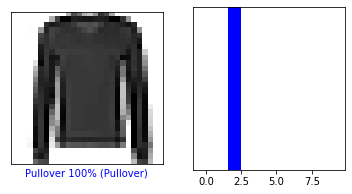

In [102]:
i = 12
plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

### Caution:
    A 100% confidence prediction can still be labeled wrong.

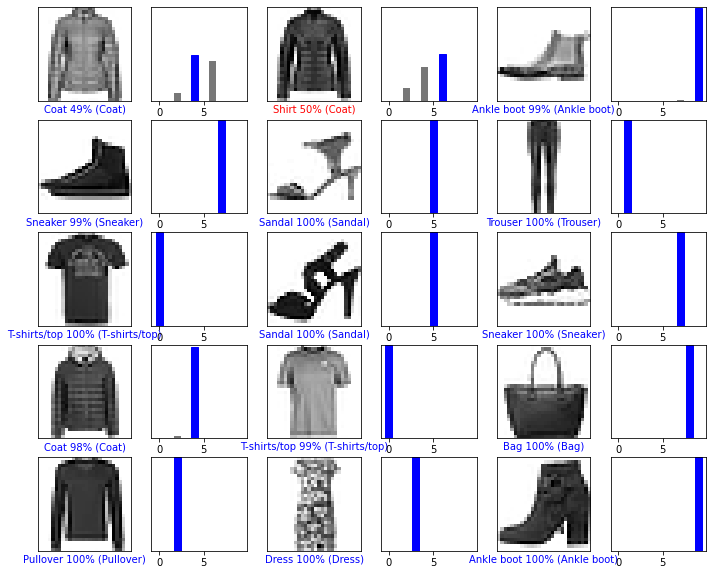

In [103]:
#Plot the first X set images, their predicted labeled, and the true label
#Color correct predictions in blue, incorrect predictions in red

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize = (2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)





### Graphing Test Prediction Results:
#### Note: We are accounting for the discrepancies.
Our results from our first 15 test images are displayed above.  The first image has a 49 percent confidence value of labeling a Coat as "Coat" and the second image has a 50 percent confidence value of labeling a Shirt as "Coat".

In [105]:
# Grab an image form the test dataset
    #Use the trained model to make a prediction about a single image
    #Recall that we want a 28 pixel by 28 pixel by one dimension  image
img = test_images[0]
print(img.shape)


(28, 28, 1)


##### Note: 
tf.keras models are optimized to make predictions on a batch or collection of examples at once.  So even though we're using a single image, we need to add it to a list.

In [106]:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)


(1, 28, 28, 1)


#### Now Predict the Image

In [107]:
predictions_single = model.predict(img)
print(predictions_single)

[[4.6855328e-04 5.8155059e-10 8.4278211e-02 1.0934377e-05 4.8620069e-01
  4.8523102e-11 4.2903909e-01 4.0369534e-09 2.5252602e-06 2.8052730e-10]]


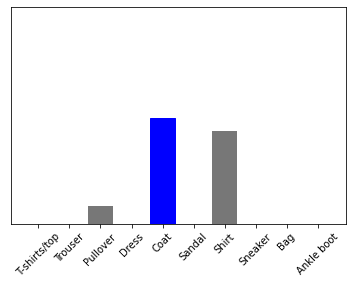

In [130]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation = 45)

#### Prediction Results:
Based upon the graph, the trained model has a confidence value greater than those of the 10 class names in the test dataset.  